In [1]:
import pandas as pd 
from selenobot.utils import DATA_DIR, dataframe_from_fasta, dataframe_to_fasta, dataframe_from_ko
from selenobot.extend import extend, translate
import os
import numpy as np
import subprocess
import time
from tqdm import tqdm 
from sklearn.decomposition import PCA
# from sklearn.linear_model import LogisticRegression
# from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score, balanced_accuracy_score
import matplotlib.pyplot as plt
import warnings 
from selenobot.extend import extend
import sklearn
import wget
import itertools
import scipy

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

In [2]:
VAL_DIR = os.path.join(DATA_DIR, 'validation', 'v3')

# Validation

Fitness data for each organism was obtained [here](https://figshare.com/articles/dataset/February_2024_release_of_the_Fitness_Browser_RB-TnSeq_data_for_diverse_bacteria_and_archaea/25236931/1).

There are a few things to try in order to get meaningful results from this data. As per Avi's advice, it is probably best to take a more directed look at the results. Start out by looking at the KEGG annotations for the hits, and seeing if they make sense. 

In [3]:
ORGANISMS = os.listdir(os.path.join(VAL_DIR, 'fitness')) # Each of the filenames is the name of the organism. :
ORGANISMS = [o.replace('db.StrainFitness.', '') for o in ORGANISMS if o != 'aaseqs'] # Remove prefixes from filenames. 
print(f'Obtained fitness data for {len(ORGANISMS)} organisms.') # NOTE: I thought there was 51?

Obtained fitness data for 49 organisms.


In [84]:
ORGANISMS

['Marino',
 'Dda3937',
 'Caulo',
 'RalstoniaGMI1000',
 'psRCH2',
 'Smeli',
 'Btheta',
 'ANA3',
 'DdiaME23',
 'Miya',
 'pseudo6_N2E2',
 'pseudo1_N1B4',
 'SB2B',
 'Koxy',
 'SynE',
 'RalstoniaUW163',
 'SyringaeB728a',
 'Korea',
 'PS',
 'Magneto',
 'Kang',
 'acidovorax_3H11',
 'WCS417',
 'Ponti',
 'pseudo5_N2C3_1',
 'RalstoniaPSI07',
 'PV4',
 'pseudo3_N2E3',
 'azobra',
 'Putida',
 'SyringaeB728a_mexBdelta',
 'DvH',
 'Cola',
 'Cup4G11',
 'BFirm',
 'RalstoniaBSBF1503',
 'Phaeo',
 'Ddia6719',
 'Methanococcus_JJ',
 'Dyella79',
 'Burk376',
 'Keio',
 'Methanococcus_S2',
 'Pedo557',
 'MR1',
 'Dino',
 'pseudo13_GW456_L13',
 'HerbieS',
 'feba.db']

In [4]:
# Download gene metadata for each organism, which contains the locations within the genomes. Put in the DATA_DIR.
for org in ORGANISMS:
    if f'{org}.tsv' not in os.listdir(os.path.join(VAL_DIR, 'metadata')): # Make sure not to download the file twice.
        output_path = os.path.join(VAL_DIR, 'metadata', f'{org}.tsv')
        subprocess.run(f'wget https://fit.genomics.lbl.gov/cgi-bin/orgGenes.cgi?orgId={org} -O {output_path}', shell=True, check=True)
        time.sleep(1)

In [5]:
# # Download experiment metadata. Used to determine which experiments to include in the analysis. 
# for org in ORGANISMS:
#     output_path = os.path.join(VAL_DIR, 'experiments', f'{org}.tsv')
#     subprocess.run(f'wget https://genomics.lbl.gov/supplemental/bigfit/html/{org}/fit_quality.tab -O {output_path}', shell=True, check=True)
#     try: # Some of the organisms don't have files for experiments, so this just saves an HTML webpage. Remove these cases. 
#         pd.read_csv(output_path, delimiter='\t')
#     except: # Remove the HTML file. 
#         subprocess.run(f'rm {output_path}', shell=True, check=True)


In [6]:
# # Download t-values. Used to determine which experiments to include in the analysis. 
# for org in ORGANISMS:
#     output_path = os.path.join(VAL_DIR, 't_values', f'{org}.tsv')
#     subprocess.run(f'wget https://genomics.lbl.gov/supplemental/bigfit/html/{org}/fit_t.tab -O {output_path}', shell=True, check=True)
#     try: # Some of the organisms don't have files for t-values, so this just saves an HTML webpage. Remove these cases. 
#         pd.read_csv(output_path, delimiter='\t')
#     except: # Remove the HTML file. 
#         subprocess.run(f'rm {output_path}', shell=True, check=True)


In [7]:
# How many total genes are there?
genes_df = dataframe_from_fasta(os.path.join(VAL_DIR, 'aaseqs.fa'), parse_header=False)
# Check to make sure we have about the right number of genes in the file...
print(len(genes_df), f'total genes obtained. This is about {np.round(len(genes_df) / len(ORGANISMS))} genes per organism.')

221030 total genes obtained. This is about 4511.0 genes per organism.


## Loading organism data

The amino acid sequences for every CDS for every organism is stored in the `aaseqs.fa` file. Metadata for the genes, which includes the scaffold, orientation, functional annotation, and start and end positions, is found in the corresponding `{organism}_metadata.tsv` file. 

A subset of the genes in `aaseqs.fa` for the particular organism are extracted and annotated with KEGG ortholog (KO) groups. Additionally, they are embedded, and predictions are generated using the trained selenoprotein classifier.

In [82]:
organism = 'ANA3'

In [83]:
# First, we need to generate a FASTA file containing only the genes from the specified organism. 
organism_genes_df = genes_df[genes_df['id'].str.contains(organism)] # Get all sequences for the specified organism.
dataframe_to_fasta(organism_genes_df, os.path.join(VAL_DIR, 'genes', f'{organism}.fa')) # Convert to a FASTA file so it can be used with the scripts. 
print(len(organism_genes_df), f'genes belonging to {organism}.')

4360 genes belonging to ANA3.


In [10]:
predictions_df = pd.read_csv(os.path.join(VAL_DIR, 'predictions', f'{organism}.csv')) # Load selenoprotein predictions. 
annotations_df = dataframe_from_ko(os.path.join(VAL_DIR, 'annotations', f'{organism}.fa.ko'), parse_header=True) # Load KEGG annotations. 
metadata_df = pd.read_csv(os.path.join(VAL_DIR, 'metadata', f'{organism}.tsv'), delimiter='\t') # Load the gene metadata.

metadata_df['id'] = metadata_df.locusId # Create an ID column to match the columns in the other DataFrames.
predictions_df['id'] = predictions_df['id'].str.replace(f'id={organism}:', '') # Remove extra stuff from ID to be compatible with annotations_df.
annotations_df['id'] = annotations_df['id'].str.replace(f'{organism}:', '') # Remove extra stuff from ID to be compatible with predictions_df.

# Combine the predictions, annotations, and metadata. 
df = predictions_df.merge(annotations_df[['ko', 'id']], on='id', how='outer')
df = df.merge(metadata_df, on='id', how='inner') # For some reason, there are more metadata entries than genes.

annotated_sec = df[~df.ko.isnull() & (df.prediction == 1)]
print(len(annotated_sec), 'predicted selenoproteins were successfully assigned a KO group.')
print(len(annotations_df), 'proteins were successfully assigned a KO group.')

1 predicted selenoproteins were successfully assigned a KO group.
2711 proteins were successfully assigned a KO group.


In [11]:
# As a control, are any proteins predicted to be in KO groups which are heavily-represented in the selenoprotein training set?
# sec_kos = dataframe_from_ko(os.path.join(DATA_DIR, 'sec.fasta.ko')).ko.values
# sec_ko_counts = [np.sum(sec_kos == ko) for ko in sec_kos]
# len(annotations_df[annotations_df.ko.isin(sec_kos)])

In [12]:
print('Number of predicted selenoproteins:', np.sum(df.prediction.values))
print('Average length of predicted selenoproteins:', df[df.prediction == 1].seq.apply(len).mean())
print('Average length of predicted non-selenoproteins:', df[df.prediction == 0].seq.apply(len).mean())

Number of predicted selenoproteins: 55.0
Average length of predicted selenoproteins: 75.43636363636364
Average length of predicted non-selenoproteins: 318.8684049704624


## Extending predicted selenoproteins

In [13]:
# Load the genome into a DataFrame which maps the scaffold ID to the scaffold sequence.
genome_df = dataframe_from_fasta(os.path.join(VAL_DIR, 'genomes', f'{organism}.fna'), parse_header=False).rename(columns={'id':'scaffold_id'})

In [14]:
extensions_df = []

for id_ in df[df.prediction == 1]['id'].values:
    row = dict()

    id_df = df[df['id'].str.fullmatch(id_)] # Get entries for the locus ID. 
    row['start'], row['stop'], row['orientation'] = id_df.begin.item(), id_df.end.item(), id_df.strand.item()

    scaffold_id = id_df.scaffoldId.item()
    contig = genome_df[genome_df.scaffold_id.str.fullmatch(scaffold_id)].seq.item()

    row.update(extend(contig=contig, **row))
    row['id'] = id_ # Add the ID after extending.
    row['scaffold_id'] = scaffold_id # Add the scaffold ID too...
    extensions_df.append(row)

extensions_df = pd.DataFrame(extensions_df)
extensions_df['seq'] = extensions_df.apply(lambda row : translate(row['seq'], orientation=row['orientation']), axis=1)

In [15]:
stop_codons = set(extensions_df.stop_codon.values)
stop_codon_counts = {c:np.sum(extensions_df.stop_codon.values == c) for c in stop_codons}
print(stop_codon_counts)

{'TAG': 17, 'TAA': 8, 'TGA': 30}


In [16]:
dataframe_to_fasta(extensions_df, f'{organism}.fa.ext')

## Analyzing fitness data

The fitness data is pretty noisy, so I am going to need to think of approaches which will limit the effect of the noise. 

One idea (from Josh) is to use the fitness value distribution for a specific feature (i.e. experimental condition) to generate p-values for (1) fitness value for transposon insertions within the predicted gene bounds (2) fitness values for transposon insertions in the extended region. Then I can compare the p-value distributions, maybe using KL divergence. 

In [17]:
fitness_df = pd.read_csv(os.path.join(VAL_DIR, 'fitness', f'db.StrainFitness.{organism}'), delimiter='\t')
fitness_df.locusId = fitness_df.locusId.fillna('None')

In [23]:
exps = [col for col in fitness_df.columns if col not in ['barcode', 'pos', 'scaffold', 'strand', 'locusId', 'used']]

In [18]:
# def get_successful_experiments():
#     experiments_df = pd.read_csv(os.path.join(VAL_DIR, 'experiments', f'{organism}.tsv'), delimiter='\t')
#     n = len(experiments_df)
#     experiments_df = experiments_df[experiments_df.u] # Reads as a boolean automatically.
#     print(f'get_successful_experiments: Used {len(experiments_df)} of {n} total experiments.')
#     return experiments_df.name.values.tolist()

In [69]:
# Load in the DataFrame of t-values.
t_df = pd.read_csv(os.path.join(VAL_DIR, 't_values', f'{organism}.tsv'), delimiter='\t')
col_map = {col:col.split()[0] for col in t_df.columns}
t_df = t_df.rename(columns=col_map)
t_df = t_df.drop(columns=['sysName', 'desc'])

def get_t_value(id_:str, experiment:str):
    '''Get the t-value for a gene in a specific experiment.'''
    return t_df[t_df.locusId.str.match('Ac3H11_4581')][experiment].item()

def filter_experiments(id_:str=None, t_threshold:int=0):
    t_values = np.array([get_t_value(id, e) for e in exps])
    t_values = np.abs(t_values) # Use the absolute values to account for negative numbers. 
    return np.array(exps)[t_values >= t_threshold]


In [29]:
def filter_fitness_df(fitness_df:pd.DataFrame, start:int=None, stop:int=None, scaffold_id:str=None):
    '''Obtain fitness data for mutants where the inserted transposon lies within the specified region.'''
    fitness_df = fitness_df[fitness_df.scaffold.str.fullmatch(scaffold_id)]  # Get all entries on the same scaffold as the locus.
    # mask = np.logical_and(mask, fitness_df.strand == strand) # Get all entries on the same strand as the locus.
    fitness_df = fitness_df[(fitness_df.pos <= stop) & (fitness_df.pos >= start)] # Get all in-window mutations.

    # # Check to make sure filtering is correct. All locus ID values in the DataFrame should be NaN or the same. 
    # locus_ids = fitness_df.locusId.values
    # locus_ids = locus_ids[~pd.isnull(locus_ids)]
    # if len(locus_ids) > 0:
    #     locus_id = locus_ids[0]
    #     assert np.all(locus_ids == locus_id), 'get_fitness: All locus IDs in filtered fitness_df should be NaN or identical.'

    return fitness_df
    

def get_extension_window(start:int=None, stop:int=None, nt_ext:int=None, orientation:str=None, scaffold_id:str=None, **kwargs):
    '''Use the original start and stop locations, as well as the size of the extension, to get the window for the extension region of the
    predicted selenoprotein.'''
    if orientation == '-':
        ext_stop = stop 
        ext_start = start - nt_ext - 1 # Not 100 percent sure I should be subtracting one again, but I think so?
    if orientation == '+':
        ext_stop = stop + nt_ext
        ext_start = start 
    return {'start':ext_start, 'stop':ext_stop, 'scaffold_id':scaffold_id}



In [30]:
# First, I want to get a sense of how many hits in the fitness DataFrame there are for each predicted selenoprotein.
n_hits = []
for row in extensions_df.itertuples(index=False):
    window = get_extension_window(**row._asdict())
    n_hits.append(len(filter_fitness_df(fitness_df, **window)))
extensions_df['n_hits'] = n_hits

In [31]:
extensions_df.sort_values('n_hits', ascending=False).head()

,start,stop,orientation,seq,stop_codon,nt_ext,aa_ext,id,scaffold_id,n_hits
40,179034,182177,-,VLLAALGMAALGVISYQKLPIDAVPDITNVQVQINTQAAGYSPLET...,TAG,444,148,Ac3H11_4581,scaffold5/1,189
46,53766,54878,+,LLLPHTTKLIAASAYPSGGNAQFDSKPSKANRLLGFEQPAADGCNS...,TAA,39,13,Ac3H11_4888,scaffold5/30,177
17,1014017,1014253,+,MKKAPAWVTALMLMCFLAGADASGAAGFPEKPIKVVTPFTPGSAPD...,TAA,735,245,Ac3H11_2713,scaffold5/16,75
51,135817,135963,+,LILPQPGRACAGLRPVMLTGTLVRARREKRTVRAEPVEALRSASTG...,TGA,321,107,Ac3H11_4973,scaffold5/30,57
39,42129,42263,+,LWKGAEDWLHGDSGGLGSGPPGRGLILRRIVAEGVVMTERCCRGUF...,TGA,111,37,Ac3H11_45,scaffold5/5,51


In [32]:
# Ac3H11_4581 = extensions_df[extensions_df['id'].str.match('Ac3H11_4581')].to_dict(orient='records')[0]
# Ac3H11_4581_window = get_extension_window(**Ac3H11_4581)
# filter_fitness_df(fitness_df, **Ac3H11_4581_window)


In [77]:
def get_cofitness(extensions_df:pd.DataFrame, fitness_df:pd.DataFrame, id_:str='Ac3H11_4581', plot:bool=False, t_threshold:int=0, min_hits:int=5):
    # Extract the row from the extension_df for the specified locus ID as a dictionary. 
    row = extensions_df[extensions_df['id'].str.fullmatch(id_)].to_dict(orient='records')[0]
    window = get_extension_window(**row)
    fitness_df = filter_fitness_df(fitness_df, **window)
    fitness_df_gene = fitness_df[fitness_df.locusId.str.fullmatch(id_)]
    fitness_df_ext = fitness_df[~fitness_df.locusId.str.fullmatch(id_)]

    if (len(fitness_df_gene) < min_hits) or (len(fitness_df_ext) < min_hits):
        return None

    exps = filter_experiments(id_=id_, t_threshold=t_threshold)

    def get_points(x_df:pd.DataFrame, y_df:pd.DataFrame):
        # Remove all non-experiment columns. 
        # exclude_cols = ['barcode', 'scaffold', 'strand', 'locusId', 'pos', 'used']
        x_vals, y_vals = x_df[exps].values, y_df[exps].values
        x_errs = x_vals.std(axis=0) / np.sqrt(len(x_vals))
        y_errs = y_vals.std(axis=0) / np.sqrt(len(y_vals))
        return x_vals.mean(axis=0), y_vals.mean(axis=0), x_errs, y_errs
    
    x_vals, y_vals, x_errs, y_errs = get_points(fitness_df_gene, fitness_df_ext)
    f = scipy.stats.linregress(x_vals, y_vals)

    ctrl_idxs = np.arange(len(fitness_df_gene))
    np.random.shuffle(ctrl_idxs) 
    ctrl_idxs = np.array_split(ctrl_idxs, 2)

    x_vals_ctrl, y_vals_ctrl, x_errs_ctrl, y_errs_ctrl = get_points(fitness_df_gene.iloc[ctrl_idxs[0]], fitness_df_gene.iloc[ctrl_idxs[1]])
    f_ctrl = scipy.stats.linregress(x_vals_ctrl, y_vals_ctrl)
        
    if plot:
        fig, ax = plt.subplots()
        ax.scatter(x_vals_ctrl, y_vals_ctrl, c='gray', alpha=0.3)
        ax.scatter(x_vals, y_vals, c='tab:blue', alpha=0.3)
        # ax.errorbar(x_vals, y_vals, xerr=x_errs, yerr=y_errs, alpha=0.3, linestyle='')

        # Plot the linear regression line. 
        x_vals = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1])
        y_vals = f.slope * x_vals + f.intercept
        y_vals_ctrl = f_ctrl.slope * x_vals + f_ctrl.intercept
        ax.plot(x_vals, y_vals_ctrl, c='gray', linestyle='--', alpha=0.3)
        ax.plot(x_vals, y_vals, c='tab:blue', linestyle='--')
        ax.legend(['in-gene control', 'cofitness with extended region'])

        ax.set_ylabel('fitness in extended region')
        ax.set_xlabel('fitness in gene')
        ax.set_title(f'Cofitness for gene {id_}')
        ax.text(0.9, 0.1, f'R={np.round(f.rvalue, 4)}', c='tab:blue', ha='right', va='bottom', transform=ax.transAxes)
        ax.text(0.9, 0.15, f'R={np.round(f_ctrl.rvalue, 4)}', c='gray', ha='right', va='bottom', transform=ax.transAxes)
        plt.show()
    
    return abs(f.rvalue)


In [81]:
extensions_df[extensions_df.stop_codon == 'TGA'].sort_values('cofitness', ascending=False).head()

,start,stop,orientation,seq,stop_codon,nt_ext,aa_ext,id,scaffold_id,n_hits,cofitness
42,244440,244583,+,VGVRGSGGIRSARINPCAGTEAISVPTVTGRALARSTQCRQKSQNV...,TGA,240,80,Ac3H11_4637,scaffold5/1,21,0.468878
39,42129,42263,+,LWKGAEDWLHGDSGGLGSGPPGRGLILRRIVAEGVVMTERCCRGUF...,TGA,111,37,Ac3H11_45,scaffold5/5,51,0.408041
48,93330,93443,+,VSPEKFLGAHGRMPLHRRNRLSIRQIGKIGPGDTIYIULLSQPPAG...,TGA,990,330,Ac3H11_4927,scaffold5/30,34,0.243673
36,81768,82037,+,VSTLVQGFGLAVRQSREARGWSQERLAEHSDLNRSYVGEIERGSVI...,TGA,117,39,Ac3H11_4306,scaffold5/2,13,0.107478
8,42578,42778,-,VGHGAMGDCDLGAAKALLQGVSRCQAWACRTRPPFAQWLHQPRGLP...,TGA,48,16,Ac3H11_1463,scaffold5/19,11,0.008926


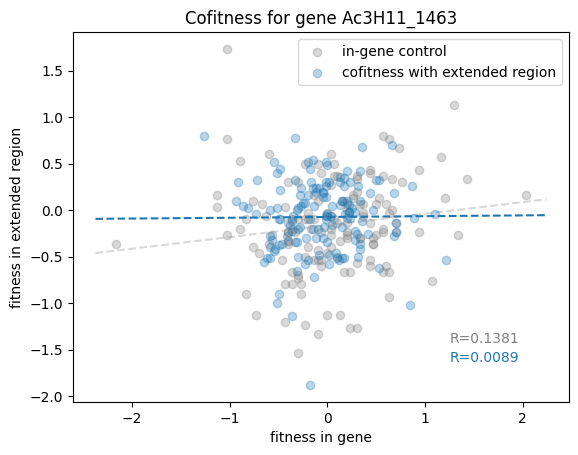

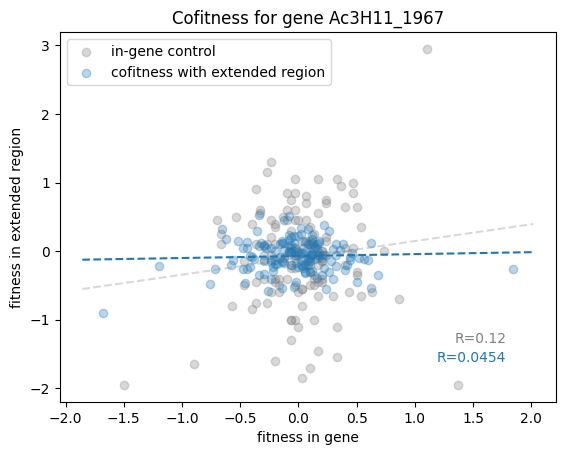

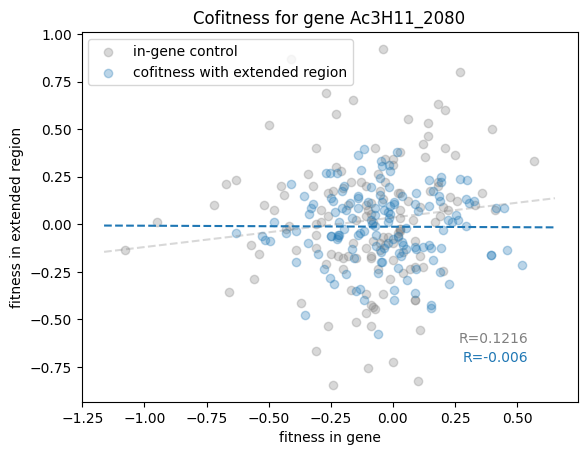

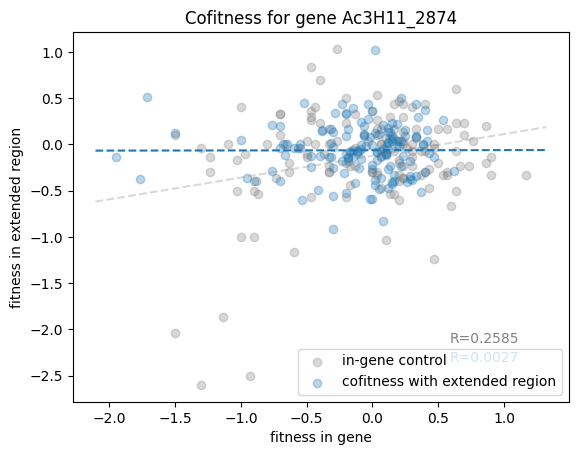

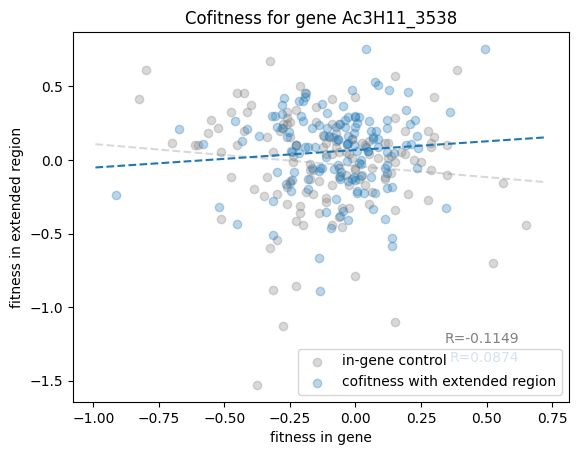

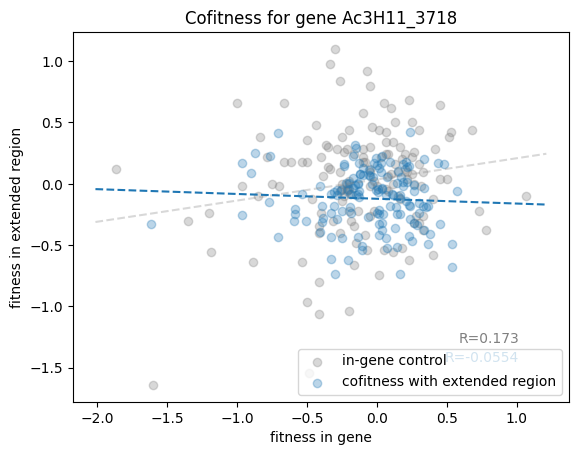

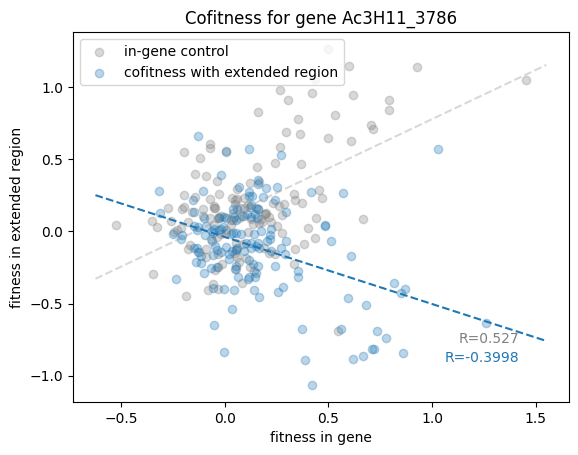

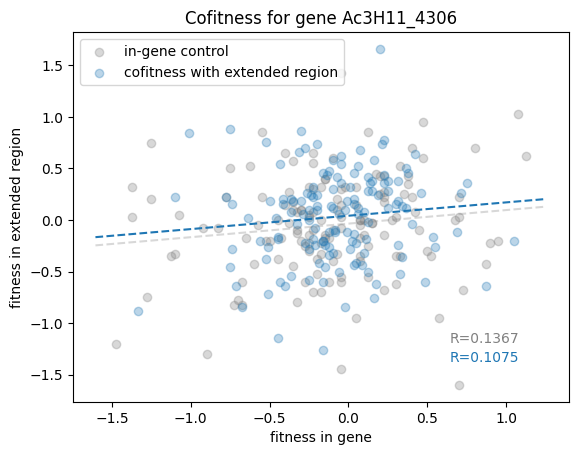

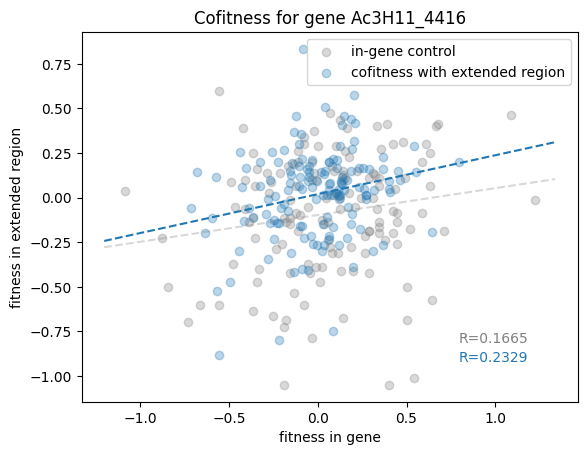

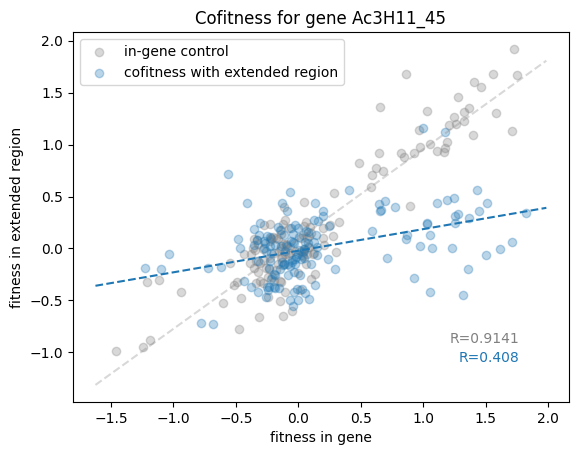

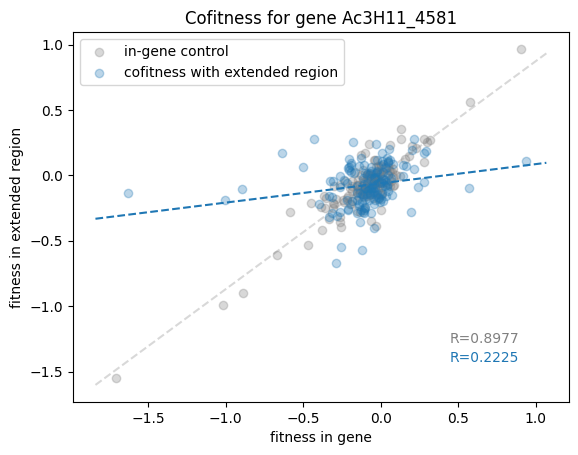

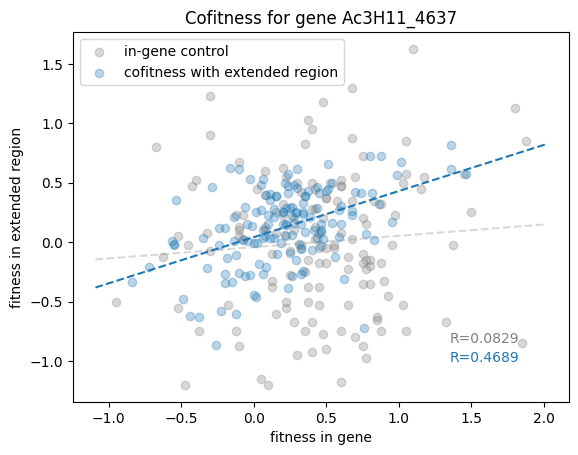

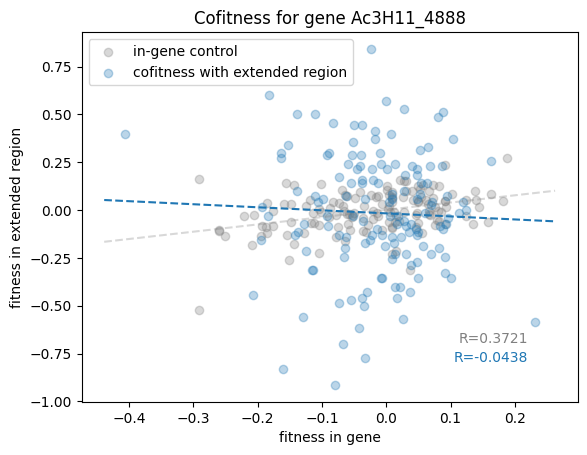

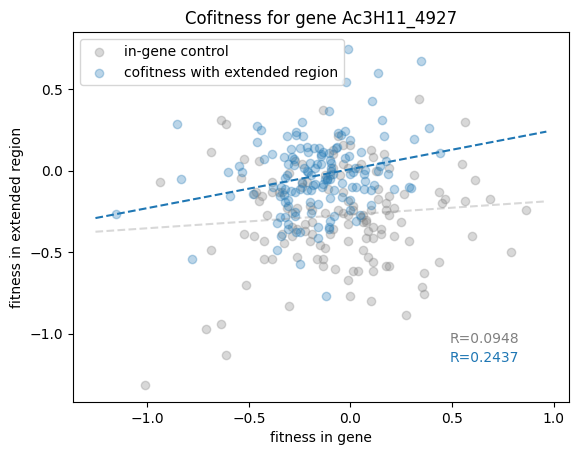

In [78]:
cofitness = []
for id_ in extensions_df['id'].values:
    cofitness.append(get_cofitness(extensions_df, fitness_df, id_=id_, plot=True))
extensions_df['cofitness'] = cofitness
# extensions_df.sort_values('cofitness', ascending=False).head()

In [79]:
get_cofitness(extensions_df, fitness_df, plot=True, id_='Ac3H11_1168')

In [ ]:
# TODO: Try splitting up in-gene observations and seeing if there is any correlation with those.
# TODO: In an attempt to reduce noise, try filtering using t-values. 
# TODO: Some kind of interference score to quantify how much of the downstream region is occupied by another gene.
# TODO: Compare to in-gene fitness values.
# TODO: Color-code experiment observations by category. 
# TODO: Maybe consider using the number of transposon mutations in the downstream region as a way to indicate if a region is useful?
# TODO: Maybe compare stop codon usage among hits to stop codon usage across the genome?